# Statistiques Exploratoires

In [48]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
nltk.download('stopwords')

nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [49]:
# Loading dataset
df_true = pd.read_csv('data/isot/raw/True.csv')
df_fake = pd.read_csv('data/isot/raw/Fake.csv')

In [50]:
df_true.shape, df_fake.shape

((21417, 4), (23481, 4))

In [51]:
df_fake.sample(5)

,title,text,subject,date
11409,FIREWORKS! THE VIEW’S CONSERVATIVE PANELIST Ge...,,politics,"Mar 14, 2017"
13706,TRUMP IS RIGHT AGAIN! While Pundits and Politi...,This is an odd report from Press TV because a ...,politics,"Jun 12, 2016"
11548,FULL INTERVIEW: PRESIDENT TRUMP Nails It On Im...,https://www.youtube.com/watch?v=hNPX8ZCIfc0&t=26s,politics,"Feb 28, 2017"
9988,CNN Publishes Inauguration Day Letter from Oba...,CNN has published the Inauguration Day letter ...,politics,"Sep 3, 2017"
11276,"YOUNG DANISH COUPLE BEATEN, Woman Punched In H...",Danish police are looking for a gang who beat ...,politics,"Mar 27, 2017"


In [52]:
df_true.sample(5)

,title,text,subject,date
7704,Exclusive: U.S. House to vote on Iran Sanction...,WASHINGTON (Reuters) - The Republican leaders ...,politicsNews,"October 25, 2016"
13457,China pushing billions into Iranian economy as...,ROME/ANKARA (Reuters) - China is financing bil...,worldnews,"November 30, 2017"
11085,Senate Democrats united on debt restructuring ...,"SAN JUAN (Reuters) - U.S. Senate Democrats, in...",politicsNews,"January 27, 2016"
20194,Swedish opposition party to call vote of no-co...,STOCKHOLM (Reuters) - Sweden s anti-immigratio...,worldnews,"September 13, 2017"
19912,Myanmar says U.S. official barred from Rohingy...,YANGON (Reuters) - Myanmar said on Friday a vi...,worldnews,"September 15, 2017"


In [53]:
def remove_intro_and_store_city_source(df):
    # Appliquer la fonction sur chaque ligne de la dataframe
    def process_row(row):
        # Extraire la portion supprimée (avant le premier tiret suivi d'un espace)
        intro = re.match(r'^.*?-\s+', row['text'])
        if intro:
            # Retirer l'intro du texte
            row['text'] = re.sub(r'^.*?-\s+', '', row['text'])
            
            # Extraction de la ville et de la source à partir de la portion supprimée
            match = re.match(r'([A-Za-z\s]+)\s\(([^)]+)\)\s-\s', intro.group(0))
            if match:
                # Extraire la ville et la source
                row['city'] = match.group(1).strip()
                row['source_name'] = match.group(2).strip()
            else:
                row['city'] = np.nan
                row['source_name'] = np.nan
        else:
            # Si aucune intro n'est trouvée, ne rien changer
            row['city'] = ''
            row['source_name'] = ''
        
        return row
    
    # Appliquer cette fonction à chaque ligne du DataFrame
    df = df.apply(process_row, axis=1)
    return df



In [54]:
df = remove_intro_and_store_city_source(df_true)


In [55]:
df

,title,text,subject,date,city,source_name
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON,Reuters
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON,Reuters
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON,Reuters
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON,Reuters
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",NaN,NaN
...,...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Dona...,worldnews,"August 22, 2017",BRUSSELS,Reuters
21413,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",worldnews,"August 22, 2017",LONDON,Reuters
21414,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories ...,worldnews,"August 22, 2017",MINSK,Reuters
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,worldnews,"August 22, 2017",MOSCOW,Reuters


# STAT Générale

In [56]:
# Taille du dataset
print("Dataset articles : TRUE")
print(f"Nombre total d'articles : {len(df)}")

# Longueur des textes et titres
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['text_wordcount'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_wordcount'] = df['title'].apply(lambda x: len(str(x).split()))

# Stats descriptives
print(df[['text_wordcount', 'title_wordcount']].describe())


Dataset articles : TRUE
Nombre total d'articles : 21417
       text_wordcount  title_wordcount
count    21417.000000     21417.000000
mean       382.148060         9.954475
std        273.951047         1.700747
min          0.000000         4.000000
25%        144.000000         9.000000
50%        356.000000        10.000000
75%        521.000000        11.000000
max       5170.000000        20.000000


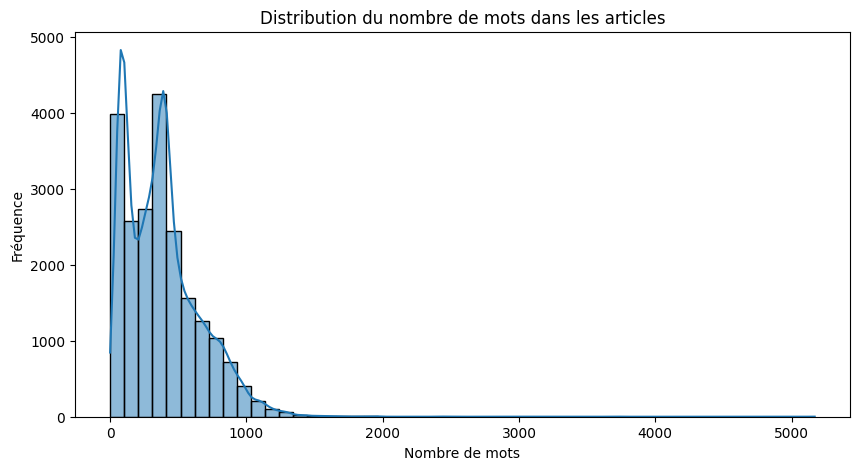

In [57]:
# Histogramme des longueurs de texte
plt.figure(figsize=(10,5))
sns.histplot(df['text_wordcount'], bins=50, kde=True)
plt.title("Distribution du nombre de mots dans les articles")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()


# Catégorie / Topic

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64
city
WASHINGTON    6444
NEW YORK       734
LONDON         709
MOSCOW         624
BERLIN         503
Name: count, dtype: int64
source_name
Reuters                       17215
                                 21
Thomson Reuters Foundation        7
IFR                               3
Reuters on Friday                 1
Name: count, dtype: int64


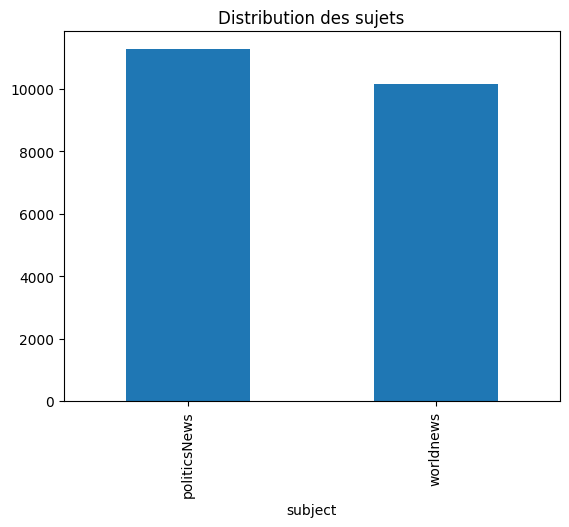

In [58]:
# Top sujets
print(df['subject'].value_counts())
df['subject'].value_counts().plot(kind='bar', title="Distribution des sujets")

# Top villes et sources
print(df['city'].value_counts().head())
print(df['source_name'].value_counts().head())


<Axes: title={'center': "Nombre d'articles par année"}, xlabel='year'>

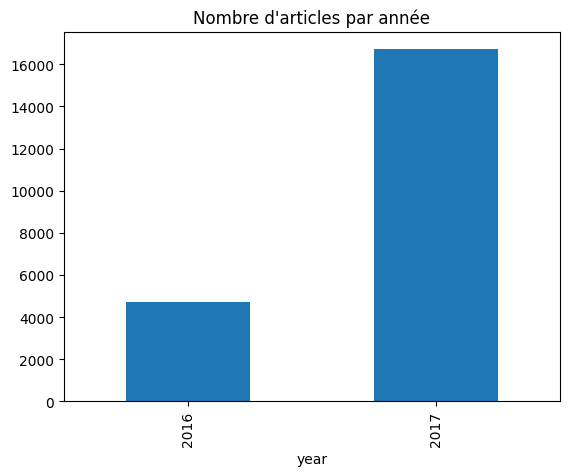

In [59]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Nombre d’articles par année
df['year'] = df['date'].dt.year
df['year'].value_counts().sort_index().plot(kind='bar', title="Nombre d'articles par année")

# Analyse du contenu 

In [60]:
nltk.data.path.append('/tmp/nltk_data')

# Ensuite importer
from nltk.corpus import stopwords
stop_words = ENGLISH_STOP_WORDS

# Fonction pour extraire les mots
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words])
    return Counter(words).most_common(n)

top_words = get_top_words(df['text'])
print("Top mots :", top_words)


Top mots : [('s', 141189), ('said', 99057), ('trump', 54591), ('u', 44459), ('president', 28072), ('state', 21020), ('government', 18844), ('states', 16652), ('house', 16636), ('republican', 16236), ('new', 15901), ('united', 15382), ('people', 15284), ('year', 14772), ('told', 14243), ('party', 12744), ('election', 12301), ('campaign', 10634), ('donald', 10356), ('security', 10159)]


In [61]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Télécharger les stopwords si ce n’est pas fait
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Liste personnalisée de mots peu informatifs
custom_stopwords = set([
    'said', 's', 'u', 'us', 'would', 'also', 'one', 'two', 'new', 'could',
    'like', 'told', 'get', 'say', 'mr', 'mrs', 'ms', 'reuters', 'reported',
    'according', 'news', 'even', 'make', 'much', 'many'
])
stop_words.update(custom_stopwords)

# Fonction pour extraire les mots fréquents
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2])
    return Counter(words).most_common(n)

# Utilisation
top_words = get_top_words(df['text'])
print("🔠 Top mots :", top_words)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/imrane/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/tmp/nltk_data'
    - '/tmp/nltk_data'
    - '/tmp/nltk_data'
    - '/tmp/nltk_data'
    - '/tmp/nltk_data'
    - '/tmp/nltk_data'
    - '/tmp/nltk_data'
**********************************************************************


# Nuage de mots

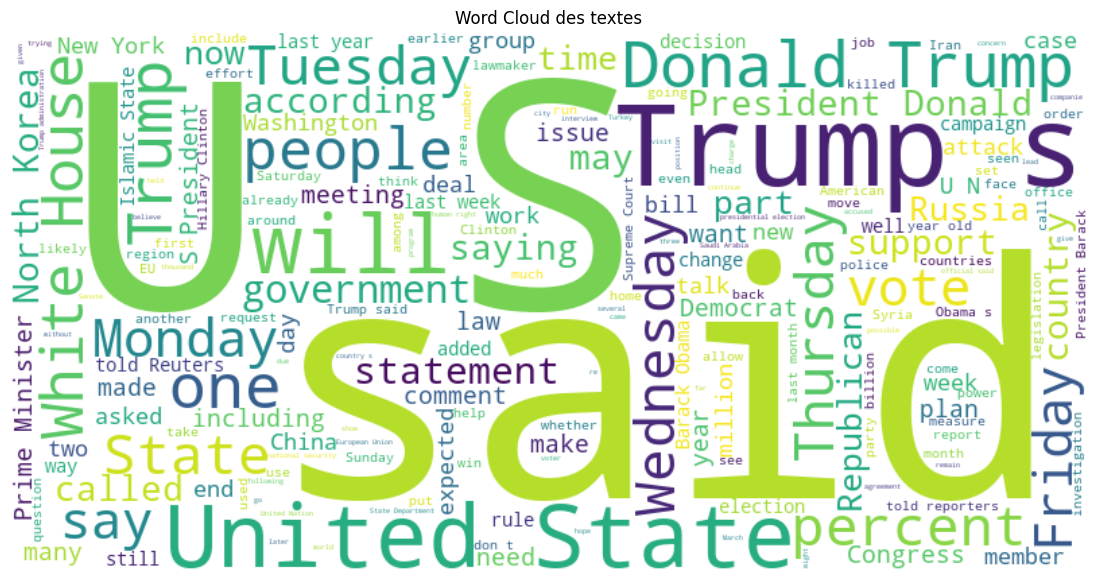

In [ ]:
text_corpus = ' '.join(df['text'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des textes")
plt.show()


# Croisements

In [ ]:
# Nombre d’articles par sujet et source
pivot = pd.pivot_table(df, index='subject', columns='source_name', aggfunc='size', fill_value=0)
print(pivot.head())

# Longueur moyenne du texte par sujet
print(df.groupby('subject')['text_wordcount'].mean())


source_name       IFR  LPC/IFR  Reuters  Reuters on Friday  \
subject                                                      
politicsNews  25    3        1     8582                  1   
worldnews      0    0        0     8629                  0   

source_name   Thomson Reuters Foundation  
subject                                   
politicsNews                           6  
worldnews                              1  
subject
politicsNews    404.408091
worldnews       357.376047
Name: text_wordcount, dtype: float64


# Données manquantes

In [ ]:
# Valeurs manquantes
print(df.isnull().sum())

# Pourcentage de manquant
print((df.isnull().mean() * 100).round(2))


title              0
text               0
subject            0
date               0
city               0
source_name        0
text_length        0
text_wordcount     0
title_wordcount    0
year               0
dtype: int64
title              0.0
text               0.0
subject            0.0
date               0.0
city               0.0
source_name        0.0
text_length        0.0
text_wordcount     0.0
title_wordcount    0.0
year               0.0
dtype: float64
